Cosmo MCMC is landing on biased HOD + Cosmology. I'm gonna first look at the code to make preds, and compare to the emulator. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path
import h5py
from ast import literal_eval

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
chain_fname = '/home/users/swmclau2/scratch/PearceMCMC/b0r0_xi_gm.hdf5'

In [4]:
f = h5py.File(chain_fname, 'r')

In [5]:
emu_type_dict = {'OriginalRecipe':OriginalRecipe,
                     'ExtraCrispy': ExtraCrispy,
                     'SpicyBuffalo': SpicyBuffalo}

fixed_params = f.attrs['fixed_params']
fixed_params = {} if fixed_params is None else literal_eval(fixed_params)
#metric = f.attrs['metric'] if 'metric' in f.attrs else {}
emu_hps = f.attrs['emu_hps']
emu_hps = {} if emu_hps is None else literal_eval(emu_hps)

seed = f.attrs['seed']
seed = int(time()) if seed is None else seed

training_file = f.attrs['training_file']
emu_type = f.attrs['emu_type']

if type(training_file) is str:
    training_file = [training_file]

if type(emu_type) is str:
    emu_type = [emu_type]
    
    

emus = []

np.random.seed(seed)
for et, tf in zip(emu_type, training_file): # TODO iterate over the others?
    emu = emu_type_dict[et](tf,
                             fixed_params = fixed_params,
                             **emu_hps)
    emus.append(emu)
    # TODO write hps to the file too

In [6]:
params = {}
sim_params = literal_eval(f.attrs['sim'])
params.update(sim_params['hod_params'])
params.update(sim_params['cosmo_params'])
del params['logMmin']

In [7]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [8]:
sim_params =  literal_eval(f.attrs['sim'])
cosmo_param_dict = sim_params['cosmo_params']

In [9]:
em_params = params
y_emu = 10**emu.emulate_wrt_r(em_params)[0]

In [10]:
boxno, realization = sim_params['sim_hps']['boxno'], sim_params['sim_hps']['realization']

In [11]:
y_calc_jk = f['data']
#y_calc_mean = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/mcmc/xi_gm_true_mean_%d%d.npy'%(boxno, realization))
y_cov_jk = f['cov']

In [12]:
emu_cov = np.loadtxt(path.join("/home/users/swmclau2/Git/pearce/bin/mcmc/config/", literal_eval(f.attrs['cov'])['emu_cov_fname']))

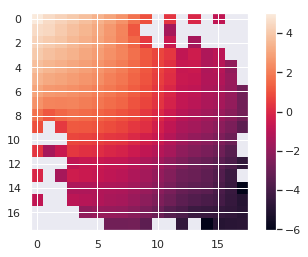

In [13]:
im = plt.imshow(np.log10(emu_cov) )
plt.colorbar(im)
plt.show()

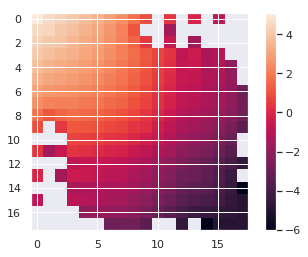

In [14]:
im = plt.imshow(np.log10(y_cov_jk) )
plt.colorbar(im)
plt.show()

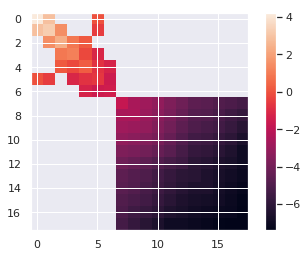

In [15]:
im = plt.imshow(np.log10(y_cov_jk-emu_cov) )
plt.colorbar(im)
plt.show()

In [16]:
print np.diag(emu_cov)
print np.diag(y_cov_jk-emu_cov)

[  1.08539897e+05   2.69382201e+04   8.53291526e+03   2.62811240e+03
   8.00645931e+02   2.74390897e+02   8.20634431e+01   2.83527878e+01
   6.86739720e+00   1.56719838e+00   2.69278194e-01   3.37824192e-02
   3.16268491e-03   9.70251154e-04   3.55097915e-04   9.01692063e-05
   2.49840542e-05   1.69990301e-05]
[  1.66651522e+04   1.95437442e+03   2.33729297e+02   1.45240374e+01
   1.88486635e+00   2.52160195e-01   3.81259500e-02   1.72874153e-02
   3.18797875e-03   7.41828197e-04   1.47402379e-04   1.98880058e-05
   2.86279943e-06   7.03619277e-07   3.27897726e-07   1.46743647e-07
   7.41369311e-08   3.90085892e-08]


In [17]:
y_err = np.sqrt(np.diag(y_cov_jk))

In [18]:
n_walkers, n_burn = f.attrs['nwalkers'], 10000
chain =  f['chain'].value[n_walkers*n_burn:]
param_names = f.attrs['param_names']

In [19]:
MAP = chain.mean(axis = 0)
print MAP

[  2.28545368e-02   1.18466951e-01  -7.96347201e-01   9.91292000e-01
   3.01353431e+00   6.42289124e+01   3.96353126e+00   1.46585617e+01
   1.83319554e-01   1.28677912e+01   1.01054406e+00]


In [20]:
em_params.update(dict(zip(param_names, MAP)))
MAP_xi = 10**emu.emulate_wrt_r(em_params)[0]

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))


In [21]:
varied_param_name = 'H0'
bounds = emu.get_param_bounds(varied_param_name)
Nvp = 100
vp_vals = np.linspace(bounds[0], bounds[1], Nvp)

varied_param_xis = []
for val in vp_vals:
    em_params[varied_param_name] = val
    varied_param_xis.append(10**emu.emulate_wrt_r(em_params))

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM1 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:497: UserWarning: One value for logM0 is outside the bounds (13.100, 14.600) of the emulator.
  pname, plow, phigh))
/home/users/swmclau2

In [22]:
chain_vals = []
rand_idxs = np.random.choice(chain.shape[0], size = 2000, replace = False)
rand_chain = chain[rand_idxs]

for row in rand_chain:
    cosmo_params = dict(zip(param_names, row))
    #cosmo_params['Neff'] = cosmo_param_dict['Neff']
    #cosmo_params['ln10As'] = cosmo_param_dict['ln10As']
    em_params.update(cosmo_params)

    chain_vals.append(10**emu.emulate_wrt_r(em_params))

In [23]:
vp_palette = sns.cubehelix_palette(Nvp)

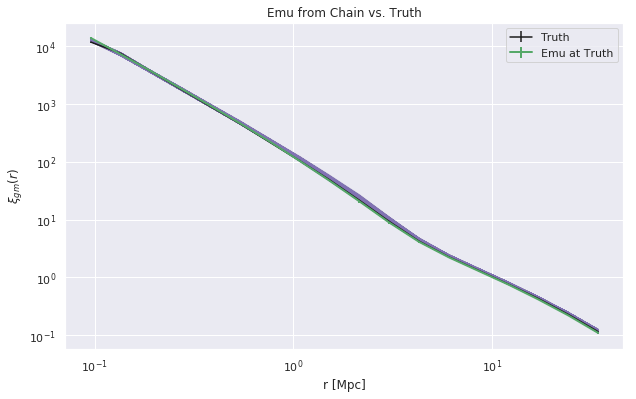

In [24]:
fig = plt.figure(figsize = (10,6))

for val in chain_vals:
    plt.plot(rpoints, val[0], c= 'm', alpha = 0.1 )
    
#for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
#    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.8)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')
plt.errorbar(rpoints, y_emu, yerr = y_err ,c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.title('Emu from Chain vs. Truth')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi_{gm}(r)$')
plt.show()

In [22]:
print y_err

[  3.53843255e+02   1.69978218e+02   9.36303613e+01   5.14065797e+01
   2.83289745e+01   1.65723582e+01   9.06099162e+00   5.32635665e+00
   2.62118011e+00   1.25217419e+00   5.19062228e-01   1.83854038e-01
   5.62632003e-02   3.11601472e-02   1.88527402e-02   9.50347042e-03
   5.00581573e-03   4.12771591e-03]


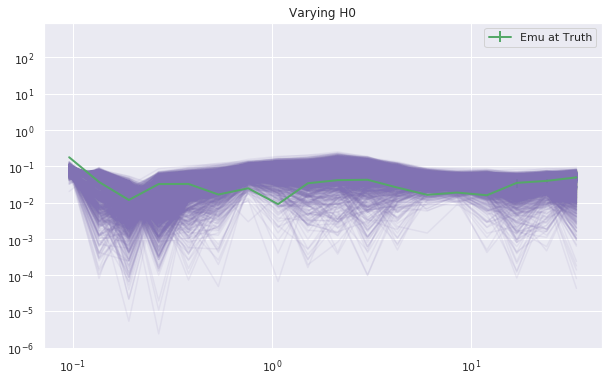

In [39]:
fig = plt.figure(figsize = (10,6))

for val in chain_vals:
    plt.plot(rpoints, np.abs(val[0]-y_calc_jk)/y_calc_jk, c= 'm', alpha = 0.1 )
    
#for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
#    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.8)
    

#plt.plot(rpoints, np.abs(MAP_xi-y_calc_jk)/y_calc_jk, label = 'MAP')
    
#plt.errorbar(rpoints, y_calc_jk.value-y_calc_jk.value, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')
plt.errorbar(rpoints, np.abs(y_emu-y_calc_jk)/y_calc_jk, yerr = y_err ,c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.show()

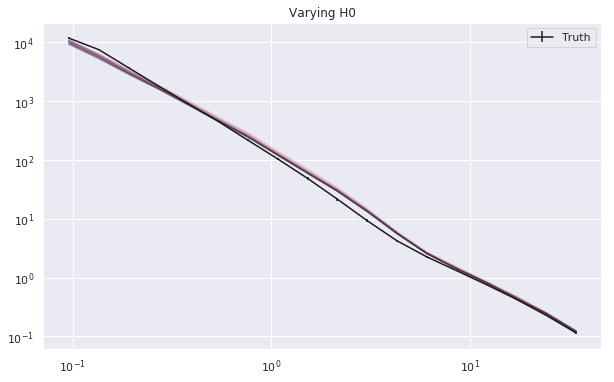

In [53]:
fig = plt.figure(figsize = (10,6))

#for val in chain_vals:
#    plt.plot(rpoints, val[0]-y_calc_jk, c= 'm', alpha = 0.1 )
    
for i, (val, pval) in enumerate(zip(varied_param_xis, vp_vals)):
    plt.plot(rpoints, val[0], color = vp_palette[i], alpha = 0.05)
    

#plt.plot(rpoints, MAP_xi, label = 'MAP')
    
plt.errorbar(rpoints, y_calc_jk, yerr= y_err,  c = 'k', label = 'Truth')
#plt.plot(rpoints, y_calc_mean  , label = 'Mean')

#plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')
#plt.xscale('log')
plt.loglog()
plt.title('Varying %s'%varied_param_name)
plt.legend(loc = 'best')
plt.show()

NameError: name 'y_err_jk' is not defined

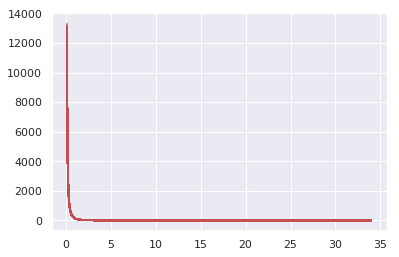

In [54]:
for val in chain_vals:
    plt.plot(rpoints, val[0], c= 'r', alpha = 0.1 )
    
#plt.errorbar(rpoints, y_calc, yerr= y_err,  c = 'k', label = 'Truth')
plt.errorbar(rpoints, y_calc_jk, yerr= y_err_jk,  c = 'b', label = 'Truth Jk')
plt.plot(rpoints, y_emu, c = 'g',lw =2, label = 'Emu at Truth')

plt.xscale('log')
#plt.loglog()
plt.legend(loc = 'best')
plt.show()

In [ ]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(121)
#plt.plot(rpoints, y_calc, label = 'Sim')
plt.plot(rpoints, y_calc, label = 'Sim')
plt.plot(rpoints, y_pred, label = 'Emu')
plt.xscale('log')
plt.legend(loc = 'best')
plt.ylabel(r'$\xi_{gg}(r)$')
plt.xlabel(r'$r$ [Mpc]')
plt.subplot(122)
#plt.plot(rpoints, y_calc/y_point, label = 'Sim')
plt.plot(rpoints, y_pred/y_calc, label = 'Emu/Sim')
plt.legend(loc = 'best')
plt.xlabel(r'$r$ [Mpc]')

plt.xscale('log')
plt.show()

In [ ]:
print y_pred/y_calc

In [ ]:
fixed_params = {'z':z, 'cosmo': 3}#, 'r':0.53882047}
train_x, train_y, _, info = emu.get_data(test_file, fixed_params, None)#, skip_nans = False)

In [ ]:
info

In [ ]:
cpv = cat._get_cosmo_param_names_vals()
cosmo_params = dict(zip(cpv[0], cpv[1]))

In [ ]:
for idx in xrange(100):
    x_point = train_x[idx*emu.n_bins, :-1]
    y_point = train_y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    pop_params = dict(zip(info['ordered_params'].keys(), x_point))

    
    #add_logMmin(pop_params, cat)
    print pop_params

    #_xi_vals = []
    #for i in xrange(10):
    #    cat.populate(pop_params, min_ptcl=100)
    #    _xi_vals.append(cat.calc_xi(r_bins))

    #xi_vals = np.log10(np.array(_xi_vals))
    #y_calc = xi_vals.mean(axis = 0)
    
    pop_params.update(cosmo_params)
    #del pop_params['logMmin']
    
    y_pred = emu.emulate_wrt_r(pop_params)[0]

    fig = plt.figure(figsize = (14, 6))

    plt.subplot(121)
    #plt.plot(rpoints, y_calc, label = 'Sim')
    plt.plot(rpoints, y_point, label = 'Data')
    plt.plot(rpoints, y_pred, label = 'Emu')
    plt.xscale('log')
    plt.legend(loc = 'best')
    plt.subplot(122)
    #plt.plot(rpoints, y_calc/y_point, label = 'Sim')
    plt.plot(rpoints, y_pred/y_point, label = 'Emu/True')
    plt.legend(loc = 'best')

    plt.xscale('log')
    plt.show()